Generative 
Makemore is character level language model. 
Each name is a sequence of characters (character level)
Modeling the sequence of characters and predicting the sequence of next character
Bigram, Bag of Words, MLP, RNN, GRU to GPT2 (Transformers)

In [75]:
from matplotlib import pyplot as plt
%matplotlib inline

In [76]:
words = open('lectures/makemore_implement/names.txt', 'r').read().splitlines()

In [77]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [78]:
len(words)

32033

In [79]:
min(len(w) for w in words)

2

In [80]:
max(len(w) for w in words)

15

In [81]:
# Find the smallest name
[ w for w in words if len(w)>=15]

['muhammadibrahim', 'muhammadmustafa']

'isabella'
i is likely to come first
s is likely to come after i
a is likely to come after is
and so on until
the word is likely to complete after isabella

So a single word has a lot of statistical structure and with 32K words, we have a lot of data to model upon



In [82]:
b ={}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
        # print(ch1, ch2)

In [83]:
sorted(b.items(), key= lambda item: item[1], reverse=True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

However it makes more sense to store the information in b as a 2D array. We will use pytorch for the same

In [84]:
import torch

Having two separate special characters creates a f
1. full column of zeros `a<S> b<S> ... ` since the `<S>` character can only come at the beginning of the word and not after any other character
2. a full row of zeros `<E>a <E>b ...` since the character `<E>` can only come at the end of the word and cannot come before any other character
Having a full row/column with zeros create an unstable tensor (matrix) that creates instability when performing backpropogation

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

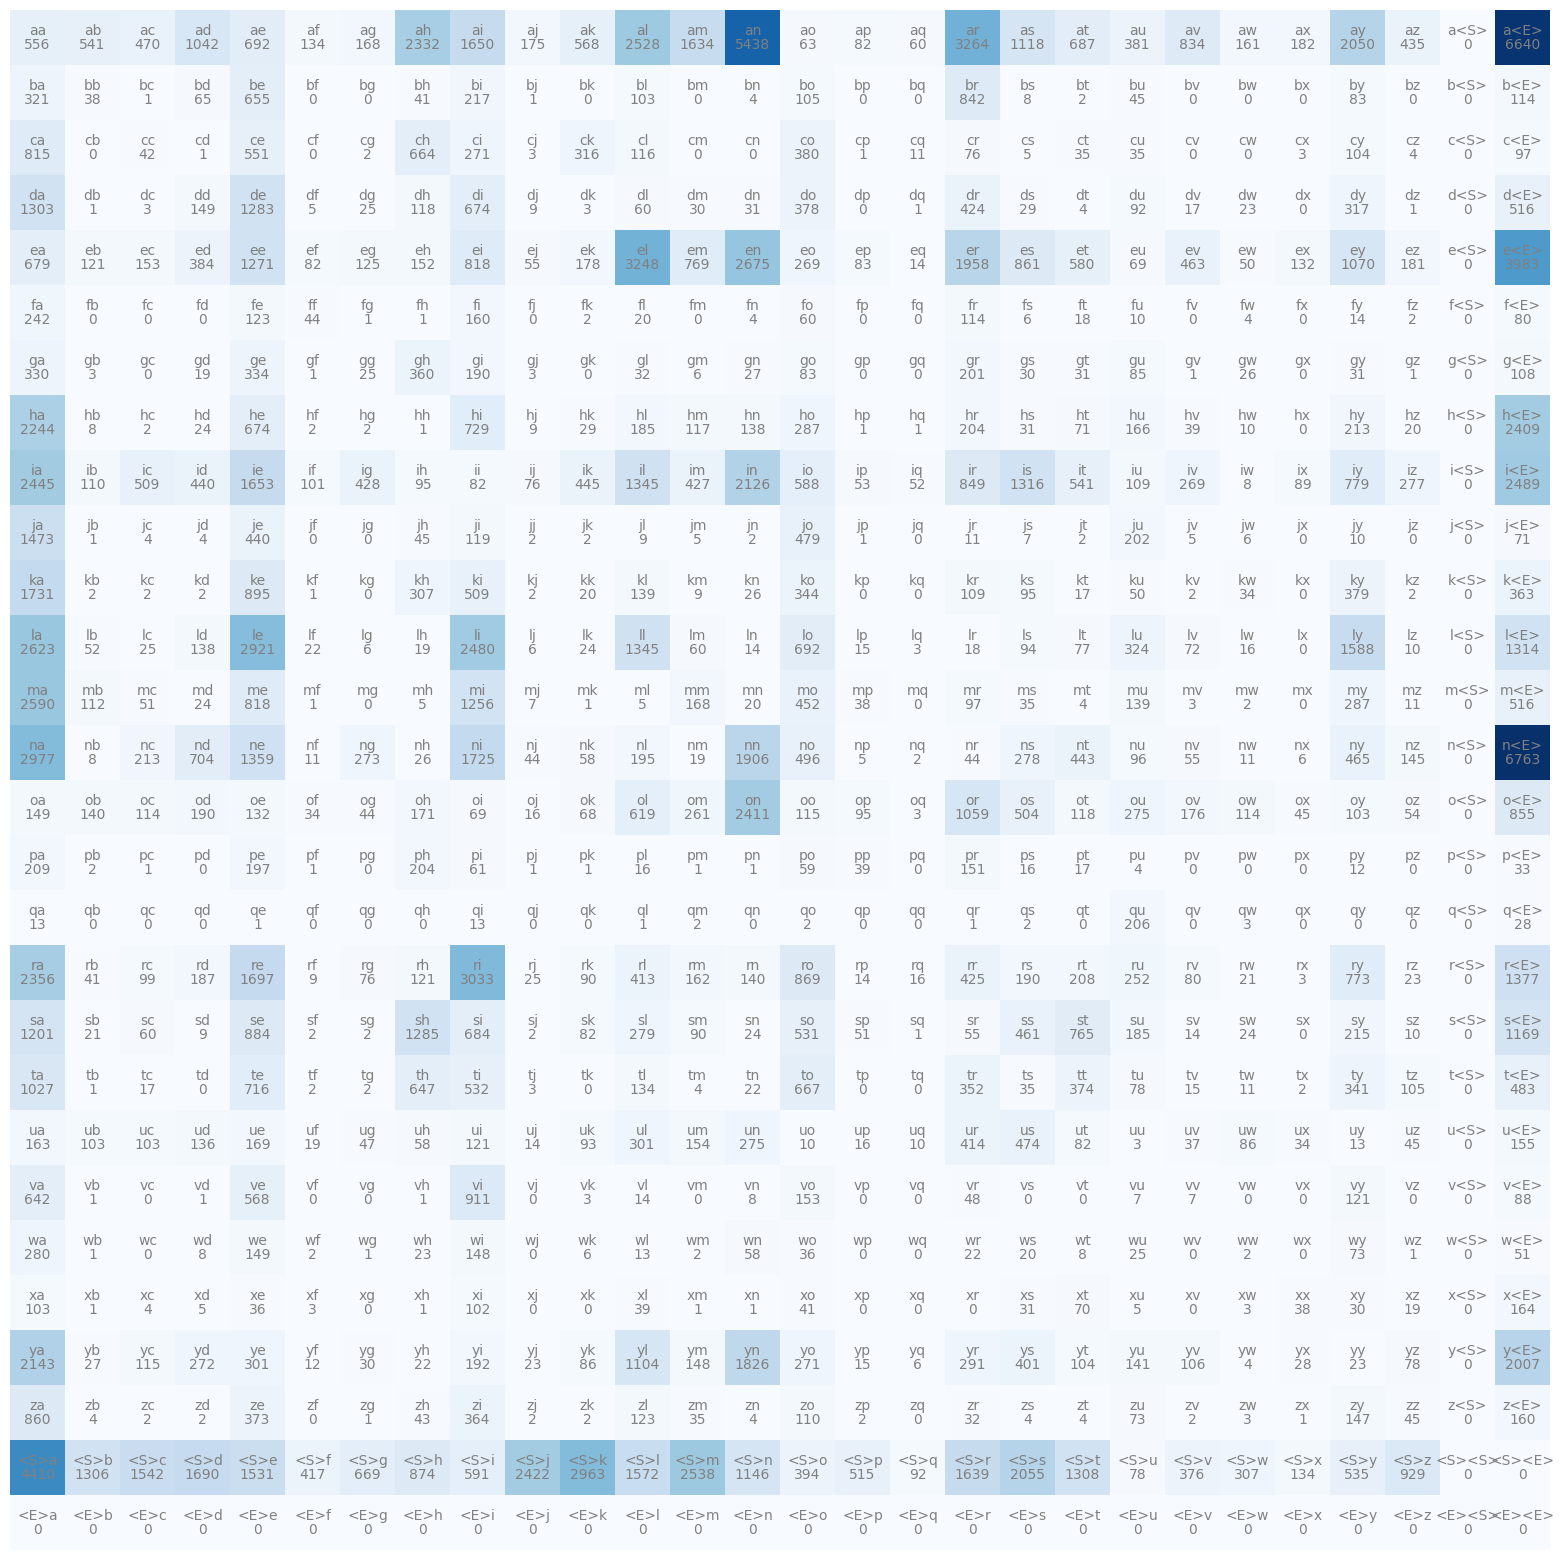

In [85]:
distinct_char_length = 28
N = torch.zeros((distinct_char_length,distinct_char_length), dtype=torch.int32)  
# Remember if you give a space in join that will be part of string and it will be considered as a character leading to 27 distinct characters. 
chars = sorted(list(set("".join(words))))
stoi = {s:i for i, s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27
itos = {i:s for s, i in stoi.items()}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1
# Plot the tensor
plt.figure(figsize=(20,20))
plt.imshow(N, cmap='Blues')
for i in range(distinct_char_length):
    for j in range(distinct_char_length):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        # .item() is needed to get the scalar value at the location
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

Instead of 2 separate characters `<S>` and `<E>` we use a single character to denote start and end called `.`. This helps to remove the zeros and the stability of the tensor (matrix).
The first row of the tensor `a. b.` indicates the likelihood of a character starting the word (name)

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

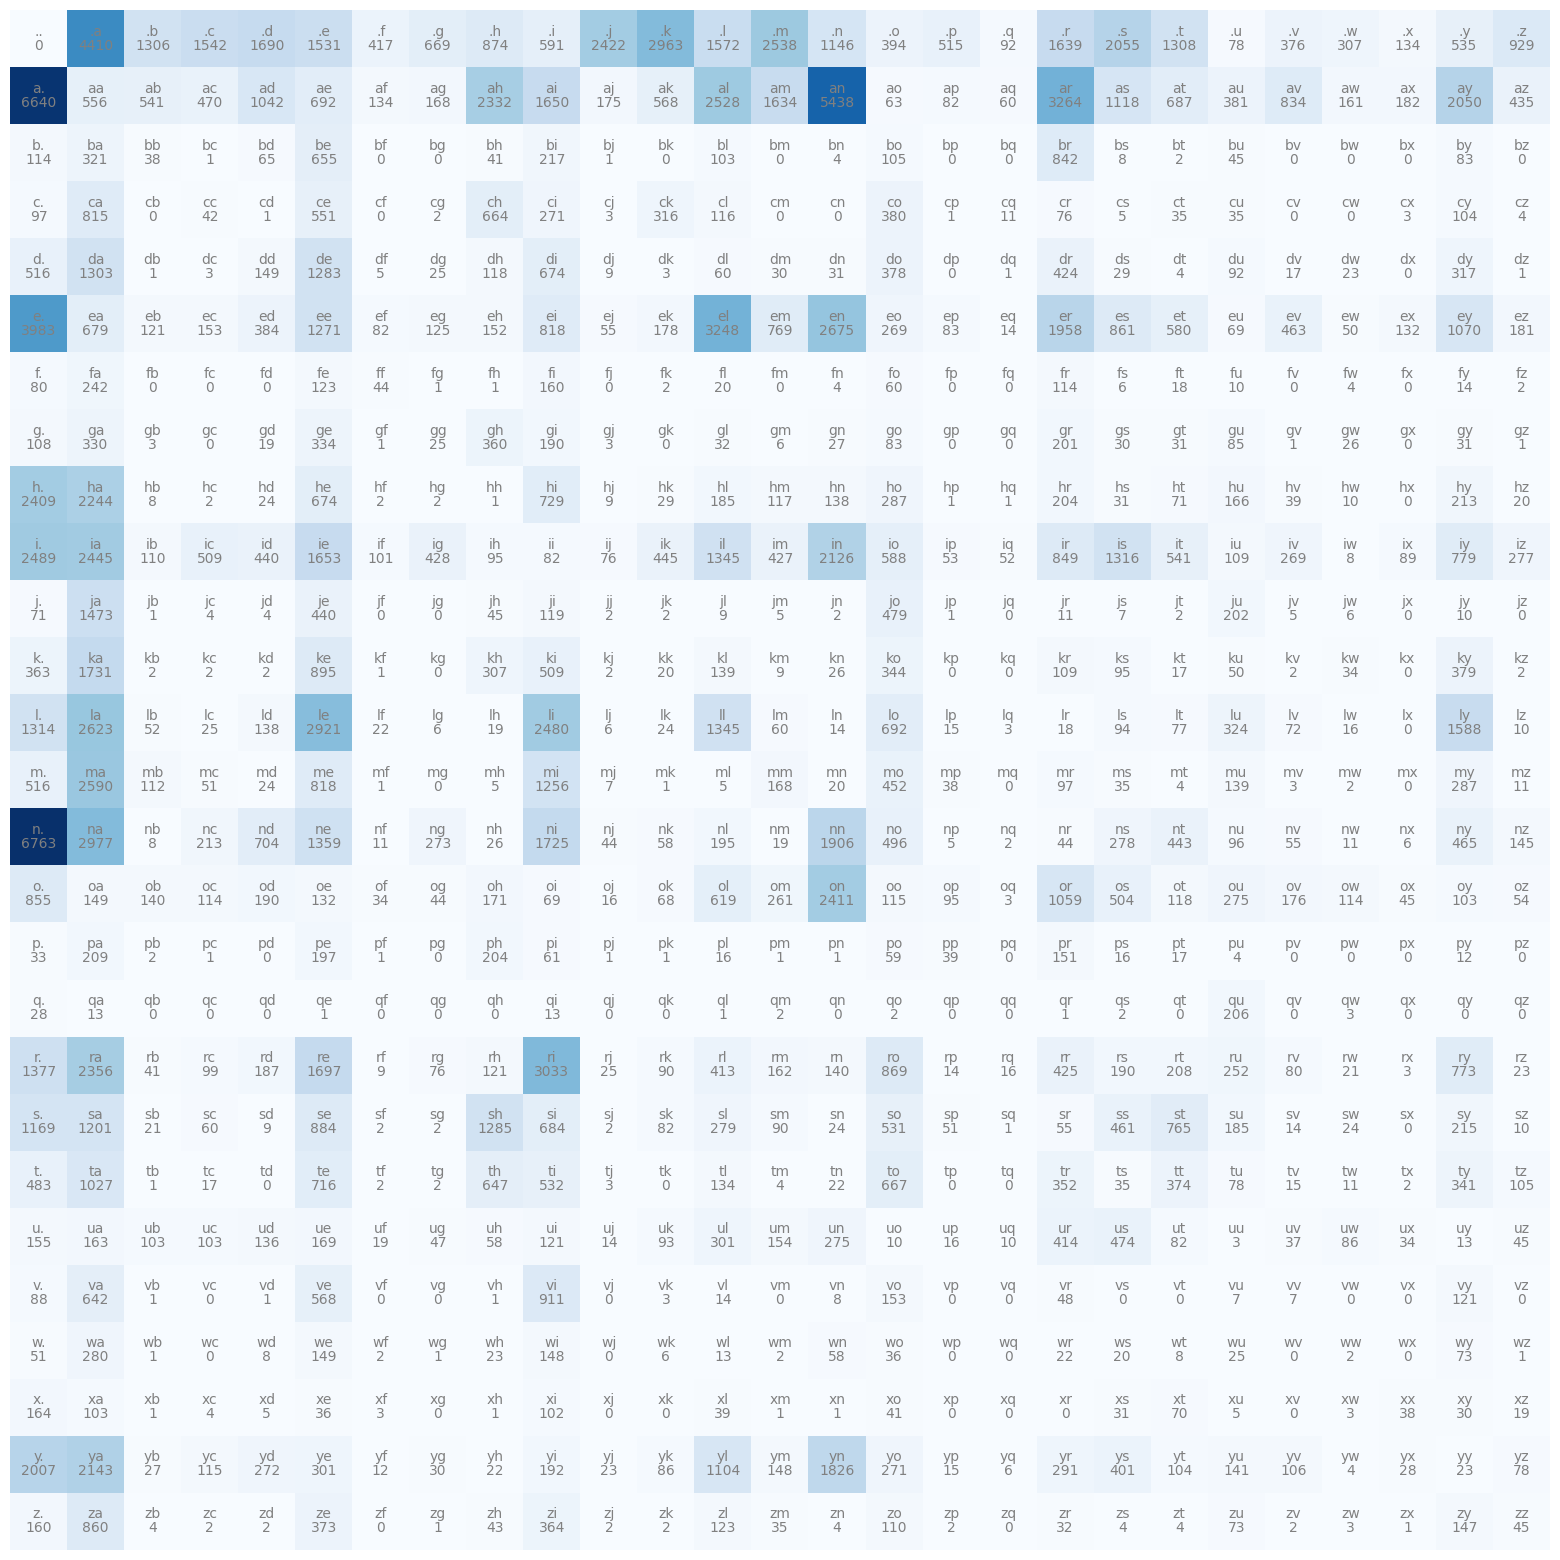

In [86]:
# Setup the tensor and the map
distinct_char_length = 27
N = torch.zeros(distinct_char_length, distinct_char_length, dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars, 1)}
stoi['.'] = 0 
itos = {i:s for s, i in stoi.items()}

# Map the bigram characters to the tensor
for w in words:
    chrlst = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chrlst, chrlst[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

# Plot the tensor with values
plt.figure(figsize=(20,20))
plt.imshow(N, cmap='Blues')
for i in range(distinct_char_length):
    for j in range(distinct_char_length):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        # .item() is needed to get the scalar value at the location
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

To create a probability distribution in N, we need to normalise it to the sum across the rows. This is achieved through following code
```py
# To test how the summation works, create a rectangular matrix
a = torch.randn(2, 3)
a/a.sum(0) # 0 is sum across row and 1 is sum across column
N.sum(1) 
```
To generate samples using multinomial distribution that are reproducible.
```py
weights = torch.tensor([0.6, 0.3, 0.1])
g_cpu = torch.Generator()
g_cpu.manual_seed(42) # Ensures the sampling is reproducible
torch.multinomial(weights, 10, replacement=True, generator=g_cpu)
```
Another way to test is as follows which generates large sequences and the sequence generated is the same everytime
```py
weights = torch.tensor([0.6, 0.3, 0.1])
g_cpu = torch.Generator()
g_cpu.manual_seed(2147483647) # Ensures the sampling is reproducible
val_dict = {0: 0, 1:0, 2:0}
for i in range(200):
    val = torch.multinomial(weights, 1, replacement=True, generator=g_cpu)
    val_dict[val.item()] += 1
# The val_dict values are repeatable and as follows
# For seed: 42, it is {0: 114, 1: 65, 2: 21} 
# For seed: 2147483647, it is {0: 124, 1: 58, 2: 18}
print(val_dict)
```

In [ ]:
# My implementation
sample_type = "uniform" # or uniform
if sample_type.strip().lower() == "bigram": 
    P = (N+1).float() # Question: The +1 is to enable stability?
    P = P/P.sum(1, keepdim=True)
elif sample_type.strip().lower() == "uniform":
    P = torch.rand(N.shape)
    P = P/P.sum(1, keepdim=True)
else:
    raise ValueError(f"sample_type can only be bigram or uniform, not {sample_type}")
g_cpu = torch.Generator().manual_seed(2147483647) # Ensures the sampling is reproducible
# print(f"Should Display 1: {P[0].sum()}") # Should return 1 which is correct
for i in range(5):
    out = []
    ix = 0
    while True:         
        p = P[ix]
        ix = torch.multinomial(p, 1, replacement=True, generator=g_cpu).item()
        out.append(itos[ix])
        if ix == 0 :
            break
    print("".join(out))


Should Display 1: 1.0
texzmkpfglkurkipqzvtyhdevmzimtznaitrlkfdk.
kavda.
sfmxvpuhjtvsrmgofzi.
iczixqwtvujjwpqedogkkjhmvmgsedgy.
nkbvgjnyhftbspmhucivgwvtahtvsu.


In [201]:
# Karpathy Implementation
P = (N+1).float()
P /= P.sum(1, keepdims=True)
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [148]:
sample = torch.multinomial(P[0], 5, replacement=True, generator=g_cpu)

In [186]:
p = P[0]

In [197]:
p_ud = torch.rand(p[0].shape)

In [198]:
(p_ud / p_ud.sum()).sum()

tensor(1.)

In [135]:
N+1

tensor([[   1, 4411, 1307, 1543, 1691, 1532,  418,  670,  875,  592, 2423, 2964,
         1573, 2539, 1147,  395,  516,   93, 1640, 2056, 1309,   79,  377,  308,
          135,  536,  930],
        [6641,  557,  542,  471, 1043,  693,  135,  169, 2333, 1651,  176,  569,
         2529, 1635, 5439,   64,   83,   61, 3265, 1119,  688,  382,  835,  162,
          183, 2051,  436],
        [ 115,  322,   39,    2,   66,  656,    1,    1,   42,  218,    2,    1,
          104,    1,    5,  106,    1,    1,  843,    9,    3,   46,    1,    1,
            1,   84,    1],
        [  98,  816,    1,   43,    2,  552,    1,    3,  665,  272,    4,  317,
          117,    1,    1,  381,    2,   12,   77,    6,   36,   36,    1,    1,
            4,  105,    5],
        [ 517, 1304,    2,    4,  150, 1284,    6,   26,  119,  675,   10,    4,
           61,   31,   32,  379,    1,    2,  425,   30,    5,   93,   18,   24,
            1,  318,    2],
        [3984,  680,  122,  154,  385, 1272,   83,